In [ ]:
from dataloader import LineMODCocoDataset
import torch
import numpy as np
from matplotlib import pyplot as plt
import json

In [ ]:
root = ''
modelsPath = 'data/lm_models/models/models_info.json'
annFile = 'train_annotations_obj1.json'


dataset = LineMODCocoDataset(root, annFile, modelsPath)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
with open(annFile, 'r') as f:
    ann = json.load(f)

In [15]:
(204/255 - 0.485) / .229

1.3755458515283845

In [4]:
img, gt_maps, proj_vertices = dataset[210]

215 (480, 640, 3)
tensor(1.5639) torch.Size([3, 480, 640])


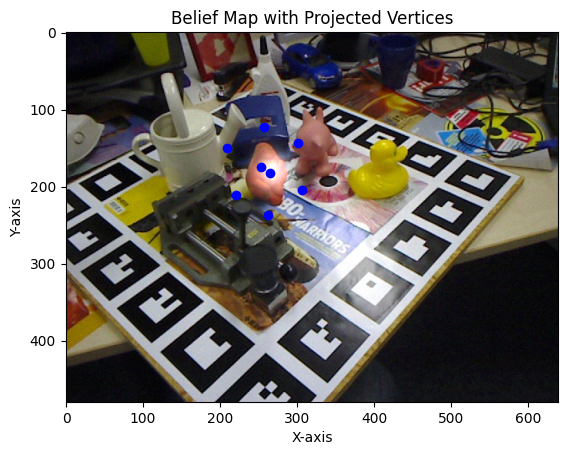

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
# Convert gt_maps[2] to a numpy array if it's not already
belief_map = gt_maps[2].numpy()*255
belief_map = belief_map.astype(np.uint8)

belief_map_resized = resize(belief_map, (img.shape[0], img.shape[1]), anti_aliasing=True)

# Ensure belief_map_resized is 3 channels by repeating it along the last axis
belief_map_resized = np.repeat(belief_map_resized[:, :, np.newaxis], 3, axis=2)

# Combine the resized belief_map with the image
combined_image = img / 255 * 1.2 + belief_map_resized

# Display the combined image
plt.imshow(combined_image)

# Overlay the projected vertices
plt.scatter(proj_vertices[0, :], proj_vertices[1, :], c='blue', marker='o')

# Optional: Add labels or titles
plt.title('Belief Map with Projected Vertices')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()


In [59]:
combined_image.min()

0.0

In [10]:
gt_maps.shape

torch.Size([25, 60, 80])

In [80]:
import numpy as np
import matplotlib.pyplot as plt


vector_fields = gt_maps[9:,:,:].numpy()
grid_width = 80
grid_height = 60
x = np.arange(grid_width)
y = np.arange(grid_height)
x, y = np.meshgrid(x, y)
vector_field_x = vector_fields[6]
vector_field_y = vector_fields[7]
vertex_x = proj_vertices[0, :] // 8
vertex_y = proj_vertices[1, :] // 8
centroid_x = np.mean(proj_vertices[0, :]) // 8
centroid_y = np.mean(proj_vertices[1, :]) // 8

vector_field_x.shape

(60, 80)

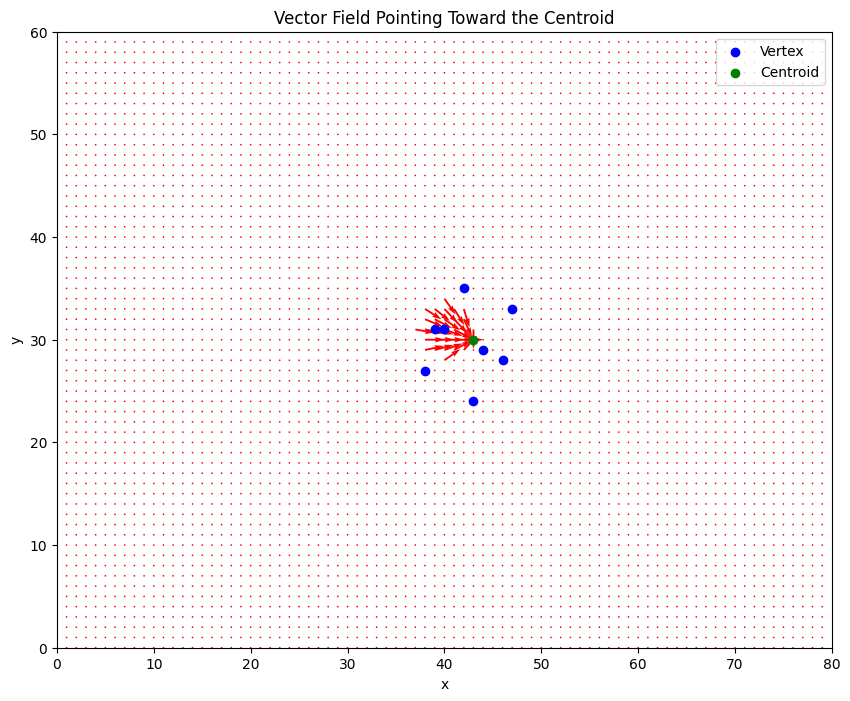

In [81]:
# Plot the vector field
plt.figure(figsize=(10, 8))
plt.quiver(x, y, vector_field_x, vector_field_y,angles='xy', scale=40, color='r')
plt.scatter([vertex_x], [vertex_y], color='b', label='Vertex')
plt.scatter([centroid_x], [centroid_y], color='g', label='Centroid')
plt.xlim(0, grid_width)
plt.ylim(0, grid_height)
plt.legend()
plt.title('Vector Field Pointing Toward the Centroid')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

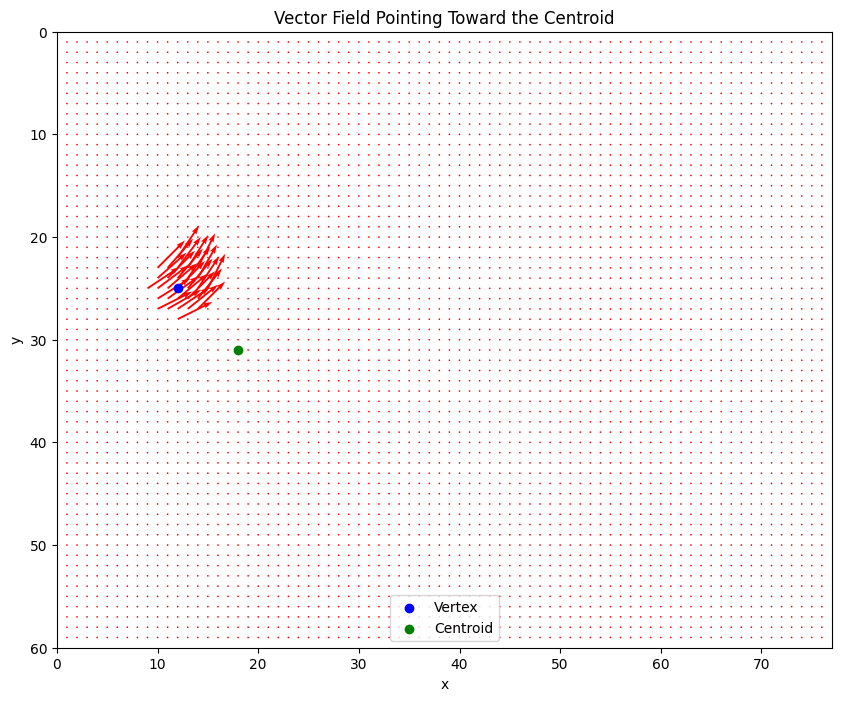

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size
grid_height = 480
grid_width = 620

# Define the vertex and centroid coordinates
vertex_x, vertex_y = 100, 200
centroid_x, centroid_y = 150, 250

# Scale down factor
scale_factor = 8

# Adjust grid size for scaled down image
scaled_height = grid_height // scale_factor
scaled_width = grid_width // scale_factor

# Create a grid of (x, y) coordinates
x = np.arange(scaled_width)
y = np.arange(scaled_height)
x, y = np.meshgrid(x, y)

# Scale down the vertex and centroid coordinates
vertex_x_scaled = vertex_x // scale_factor
vertex_y_scaled = vertex_y // scale_factor
centroid_x_scaled = centroid_x // scale_factor
centroid_y_scaled = centroid_y // scale_factor

# Initialize the vector field with zeros (using float type)
vector_field_x = np.zeros((scaled_height, scaled_width), dtype=float)
vector_field_y = np.zeros((scaled_height, scaled_width), dtype=float)

# Compute the distance from each pixel to the vertex
distance = np.sqrt((x - vertex_x_scaled)**2 + (y - vertex_y_scaled)**2)

# Set the radius within which the vector components will be computed
radius = 3

# Find the indices of pixels within the specified radius
within_radius = distance <= radius

# Compute the vector components pointing toward the centroid
vector_x = centroid_x_scaled - x.astype(float)
vector_y = centroid_y_scaled - y.astype(float)

# Normalize the vectors
magnitude = np.sqrt(vector_x**2 + vector_y**2)
non_zero = magnitude > 0
vector_x[non_zero] /= magnitude[non_zero]
vector_y[non_zero] /= magnitude[non_zero]

# Set the vector components within the radius
vector_field_x[within_radius] = vector_x[within_radius]
vector_field_y[within_radius] = vector_y[within_radius]

# Plot the vector field
plt.figure(figsize=(10, 8))
plt.quiver(x, y, vector_field_x, vector_field_y, scale=20, color='r')
plt.scatter([vertex_x_scaled], [vertex_y_scaled], color='b', label='Vertex')
plt.scatter([centroid_x_scaled], [centroid_y_scaled], color='g', label='Centroid')
plt.xlim(0, scaled_width)
plt.ylim(0, scaled_height)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Vector Field Pointing Toward the Centroid')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


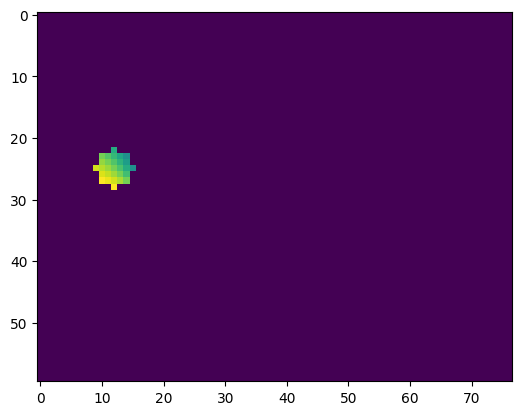

In [44]:
plt.imshow(vector_field_x)

In [14]:
vector_field_x.max()

0.70710677

0.7071067811865476 0.0
0.0 0.0
1.0 0.4472135954999579
1.0 0.7071067811865475
1.0 1.0
0.0 1.0
1.0 0.8574929257125441
0.4472135954999579 1.0


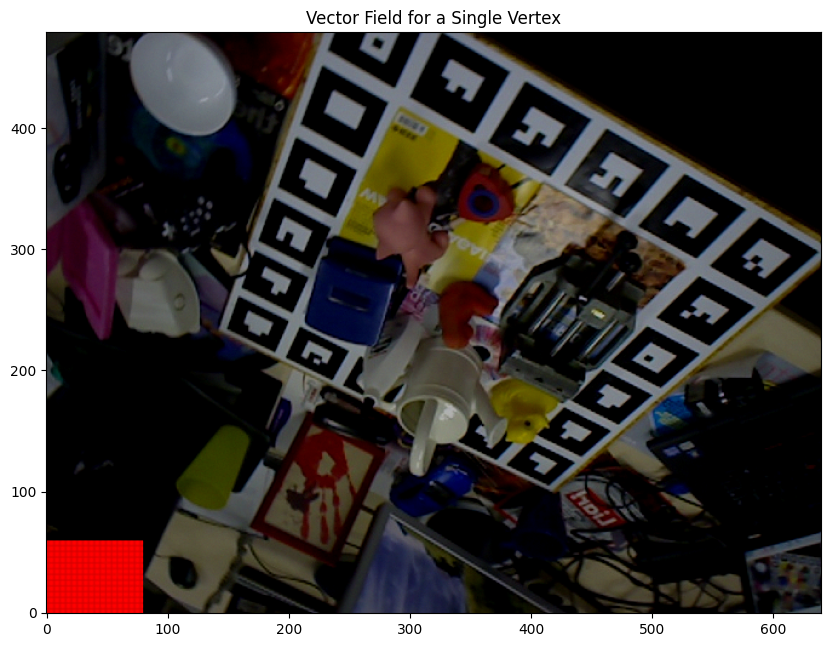

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming this function and dataset initialization code is executed beforehand
# dataset = LineMODCocoDataset(root, annFile, modelsPath)
img, target, gt_maps, proj_vertices = dataset[500]

# Convert the tensor image back to numpy
img = img.numpy().transpose(1, 2, 0) * 255
img = img.astype(np.uint8)

# Extract the vector fields from the ground truth maps
# Vector fields are stored in the first 16 channels of gt_maps
vector_fields = gt_maps[:16]

# Select the vector field for a single vertex (e.g., the first vertex)
vx = vector_fields[0]
vy = vector_fields[1]

# Downscale the image to match the belief map size
import cv2
h, w = vx.shape
# img_resized = cv2.resize(img, (w, h))

# Create a grid of coordinates
y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')

# Plot the vector field overlayed on the resized image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.quiver(x, y, vx, vy, scale=1, scale_units='xy', color='r')
plt.title('Vector Field for a Single Vertex')
plt.gca().invert_yaxis()
plt.show()
